In [1]:
import pandas as pd
import numpy as np
import datetime
from EvGym import config

save = True

In [2]:
pd.Timedelta(2.333, unit='h')

Timedelta('0 days 02:19:58.800000')

In [3]:
file = "data/data-SDG/0 Generated sample (AC,poisson_fit) Horizon =2015-01-01-to-2015-12-31.csv"
df_sdg = pd.read_csv(file, parse_dates = ["Date"])
df_sdg = df_sdg.drop(["AM_specs", "MMc_specs", "MMe_specs"], axis = 1)
len(df_sdg)
df_sdg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362125 entries, 0 to 362124
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date             362125 non-null  datetime64[ns]
 1   Arrival          362125 non-null  float64       
 2   Connected_time   362125 non-null  float64       
 3   Energy_required  362125 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.1 MB


In [4]:
df_sdg["starttime_parking"] = df_sdg["Date"] + pd.to_timedelta(df_sdg["Arrival"], unit='h')
df_sdg["month"] = df_sdg["starttime_parking"].dt.month
df_sdg["day"] = df_sdg["starttime_parking"].dt.day
df_sdg["ts_arr"] = np.floor((df_sdg["starttime_parking"] - config.starttime_min).dt.total_seconds()/ config.timestep)
df_sdg["ts_dep"] = np.ceil(df_sdg["ts_arr"] +  df_sdg["Connected_time"])
#df_sdg["soc_arr"] = np.clip(config.FINAL_SOC - 0.01 -df_sdg["Energy_required"]**config.sdg_pot / config.sdg_norm,
#                             0, config.FINAL_SOC)

# As laxity is crucial, and the SDG data is not very realistic, we will calculate laxity ourselves
df_sdg["laxity"] = np.clip((df_sdg["Connected_time"] * config.sdg_norm)**config.sdg_pot - df_sdg["Connected_time"]*np.random.uniform(0, 0.4, size = len(df_sdg)), 0, df_sdg["Connected_time"])
df_sdg["soc_arr"] = (df_sdg["laxity"] - np.ceil(df_sdg["Connected_time"]))*config.alpha_c * config.eta_c / config.B + config.FINAL_SOC + np.random.uniform(0, 0.1, size = len(df_sdg))
df_sdg["soc_arr"] = np.clip(df_sdg["soc_arr"], 0, config.FINAL_SOC)
df_sdg["laxity"] = np.ceil(df_sdg["Connected_time"]) - (config.FINAL_SOC - df_sdg["soc_arr"])*config.B / (config.alpha_c * config.eta_c)
df_sdg["session"] = df_sdg.index

In [5]:
df_sdg[["Connected_time", "laxity"]].describe()

,Connected_time,laxity
count,362125.000000,362125.000000
mean,6.376973,3.281252
std,5.129841,4.359218
min,0.000181,0.000005
25%,2.234599,0.484455
50%,4.501333,1.074399
75%,9.859067,4.801484
max,23.998291,24.000000


In [6]:
if save: df_sdg.to_csv("data/df_sdg1_preproc_all.csv", index = False)

In [7]:
# EDA
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
def get_max_occ(df_ev):
    bins = list(range(int(df_ev["ts_arr"].min()), int(df_ev["ts_dep"].max() + 1)))
    hist_start, _ = np.histogram(df_ev["ts_arr"], bins = bins)
    hist_stop, _ = np.histogram(df_ev["ts_dep"], bins = bins)
    occupancy = (hist_start - hist_stop).cumsum()
    max_occ = occupancy.max()
    return max_occ

In [10]:
idx_array = df_sdg["session"].values
idx_array = np.random.permutation(idx_array)
idxs_splits = np.array_split(idx_array, 30)
df_sdg["split"] = -1
for i, arr in enumerate(idxs_splits):
    df_sdg.loc[arr, "split"] = i
    df_sdg_sub = df_sdg[df_sdg["split"] == i]
    if save: df_sdg_sub.to_csv(f"data/preproc-SDG-splits/df_sdg1_preproc_{i}.csv", index = False)
    max_occ = get_max_occ(df_sdg_sub)
    print(f"{len(arr)=}, {len(df_sdg_sub)=}, {max_occ=}, {df_sdg_sub['Connected_time'].min()=}")


len(arr)=12071, len(df_sdg_sub)=12071, max_occ=24, df_sdg_sub['Connected_time'].min()=0.0010371341508075
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=24, df_sdg_sub['Connected_time'].min()=0.0027380336847813
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=25, df_sdg_sub['Connected_time'].min()=0.0013650876497584
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=25, df_sdg_sub['Connected_time'].min()=0.0002900097698288
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=25, df_sdg_sub['Connected_time'].min()=0.000387569837061
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=26, df_sdg_sub['Connected_time'].min()=0.0032430207789448
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=25, df_sdg_sub['Connected_time'].min()=0.0009685705902967
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=25, df_sdg_sub['Connected_time'].min()=0.0028073737392971
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=25, df_sdg_sub['Connected_time'].min()=0.0041043160983622
len(arr)=12071, len(df_sdg_sub)=12071, max_occ=23, df_sd

<Axes: xlabel='split', ylabel='ts_arr'>

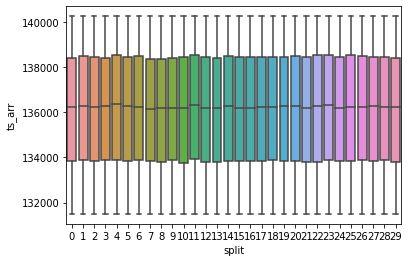

In [11]:
sns.boxplot(x="split", y="ts_arr", data=df_sdg)

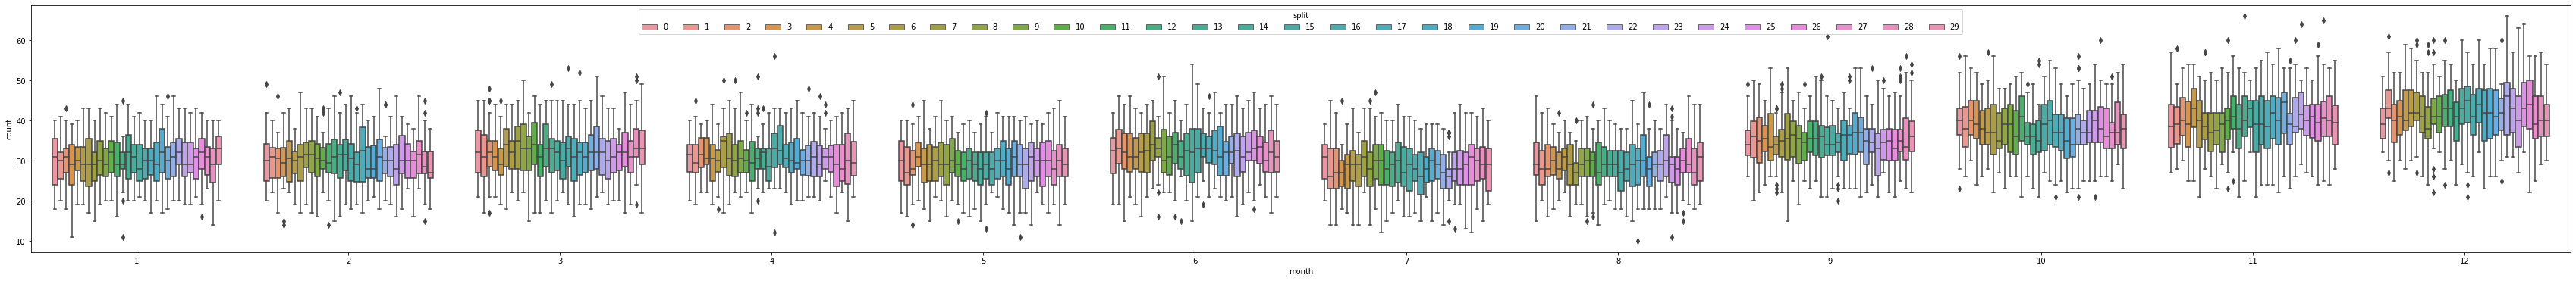

In [13]:
count_sdg = df_sdg.groupby(["day", "month", "split"]).agg(count = ("session", "count")).reset_index()
fig1 = plt.figure(figsize=(60, 6))
ax1 = fig1.add_subplot(111)
sns.boxplot(x="month", y="count", hue = "split",  data=count_sdg, ax = ax1)
sns.move_legend(ax1, "upper center", ncol = 30)


# Make the sized datasets

In [84]:
def trim_endtime(df):
    df["endtime_parking"] = df["ts_dep"].apply(ts_to_datetime)
    df = df[df["endtime_parking"].dt.year < 2016].reset_index(drop = True)
    return df

def ts_to_datetime(ts, offset = 0):
    return config.starttime_min + datetime.timedelta(seconds = (ts + offset)*config.timestep)

def translate_date_df(df_org, offset):
    df = df_org.copy()
    df["ts_arr"] = df["ts_arr"] + offset    
    df["ts_dep"] = df["ts_dep"] + offset
    df["starttime_parking"] = df["ts_arr"].apply(ts_to_datetime)
    df["endtime_parking"] = df["ts_dep"].apply(ts_to_datetime)
    df["Date"] = df["starttime_parking"].dt.date
    return df

In [85]:
df_sdg_sub_1 = pd.read_csv(f"data/preproc-SDG-splits/df_sdg1_preproc_1.csv", parse_dates = ["Date", "starttime_parking"])
df_sdg_sub_2 = pd.read_csv(f"data/preproc-SDG-splits/df_sdg1_preproc_2.csv", parse_dates = ["Date", "starttime_parking"])
df_sdg_sub_3 = pd.read_csv(f"data/preproc-SDG-splits/df_sdg1_preproc_3.csv", parse_dates = ["Date", "starttime_parking"])
df_sdg_sub_4 = pd.read_csv(f"data/preproc-SDG-splits/df_sdg1_preproc_4.csv", parse_dates = ["Date", "starttime_parking"])
df_sdg_sub_5 = pd.read_csv(f"data/preproc-SDG-splits/df_sdg1_preproc_5.csv", parse_dates = ["Date", "starttime_parking"])
df_sdg_sub_6 = pd.read_csv(f"data/preproc-SDG-splits/df_sdg1_preproc_6.csv", parse_dates = ["Date", "starttime_parking"])

df_sdg_sub_1 = trim_endtime(df_sdg_sub_1)
df_sdg_sub_2 = trim_endtime(df_sdg_sub_2)
df_sdg_sub_3 = trim_endtime(df_sdg_sub_3)
df_sdg_sub_4 = trim_endtime(df_sdg_sub_4)
df_sdg_sub_5 = trim_endtime(df_sdg_sub_5)
df_sdg_sub_6 = trim_endtime(df_sdg_sub_6)

In [86]:
df_sdg_sub_1.describe()

,Date,Arrival,Connected_time,Energy_required,starttime_parking,month,day,ts_arr,ts_dep,laxity,soc_arr,session,split,endtime_parking
count,12063,12063.000000,12063.000000,12063.000000,12063,12063.000000,12063.000000,12063.000000,12063.000000,12063.000000,12063.000000,12063.000000,12063.0,12063
mean,2015-07-13 15:45:54.837105408,13.274930,6.369115,7.547847,2015-07-14 05:02:24.585148416,6.908398,15.715825,136156.541491,136163.414573,3.271800,0.484727,182216.105695,1.0,2015-07-14 11:24:52.464561152
min,2015-01-01 00:00:00,0.142857,0.002738,0.002050,2015-01-01 01:30:00,1.000000,1.000000,131497.000000,131507.000000,0.000013,0.000000,3.000000,1.0,2015-01-01 11:00:00
25%,2015-04-10 00:00:00,9.163451,2.267036,4.518504,2015-04-10 10:28:53.333333504,4.000000,8.000000,133882.000000,133887.500000,0.475100,0.300690,91852.000000,1.0,2015-04-10 15:30:00
50%,2015-07-19 00:00:00,13.590361,4.467251,7.587692,2015-07-19 07:44:00,7.000000,16.000000,136279.000000,136284.000000,1.036669,0.497751,182428.000000,1.0,2015-07-19 12:00:00
75%,2015-10-19 00:00:00,17.019150,9.847391,9.892411,2015-10-19 07:35:13.953488384,10.000000,23.000000,138487.000000,138493.000000,4.801484,0.685949,272714.500000,1.0,2015-10-19 13:00:00
max,2015-12-31 00:00:00,23.928571,23.989540,23.899632,2015-12-31 19:37:46.666666668,12.000000,31.000000,140251.000000,140254.000000,24.000000,0.970000,361974.000000,1.0,2015-12-31 22:00:00
std,NaN,4.750244,5.133283,3.942125,NaN,3.532165,8.834501,2593.756259,2593.552766,4.364008,0.251955,104762.016631,0.0,NaN


In [91]:
df_sdg_sub_proc_1 = translate_date_df(df_sdg_sub_1, (-1)*(365 * 24))
df_sdg_sub_proc_2 = translate_date_df(df_sdg_sub_2, (0)*(365 * 24))
df_sdg_sub_proc_3 = translate_date_df(df_sdg_sub_3, (1)*(365 * 24))
df_sdg_sub_proc_4 = translate_date_df(df_sdg_sub_4, (2)*(365 * 24)+24)
df_sdg_sub_proc_5 = translate_date_df(df_sdg_sub_5, (3)*(365 * 24)+24)
df_sdg_sub_proc_6 = translate_date_df(df_sdg_sub_6, (4)*(365 * 24)+24)

df_synth_sessions_2014_2018 = pd.concat((df_sdg_sub_proc_1, df_sdg_sub_proc_2, df_sdg_sub_proc_3, df_sdg_sub_proc_4, df_sdg_sub_proc_5))
df_synth_sessions_2019 = df_sdg_sub_proc_6

In [95]:
display(df_synth_sessions_2014_2018.describe())
display(df_synth_sessions_2019.describe())

df_synth_sessions_2014_2018.to_csv("data/df_synth_sessions_2014_2018.csv", index = False)
df_synth_sessions_2019.to_csv("data/df_synth_sessions_2019.csv", index = False)

,Arrival,Connected_time,Energy_required,starttime_parking,month,day,ts_arr,ts_dep,laxity,soc_arr,session,split,endtime_parking
count,60304.000000,60304.000000,60304.000000,60304,60304.000000,60304.000000,60304.000000,60304.000000,60304.000000,60304.000000,60304.000000,60304.000000,60304
mean,13.315735,6.373081,7.514622,2016-07-13 02:45:30.624834304,6.893357,15.700832,144914.758507,144921.634518,3.283465,0.485904,181687.135049,3.000000,2016-07-13 09:38:04.266383872
min,0.083333,0.000290,0.000642,2014-01-01 01:00:00,1.000000,1.000000,122737.000000,122747.000000,0.000013,0.000000,0.000000,1.000000,2014-01-01 11:00:00
25%,9.250000,2.224800,4.530048,2015-04-09 09:45:00,4.000000,8.000000,133857.750000,133862.750000,0.481080,0.302085,91476.750000,2.000000,2015-04-09 14:45:00
50%,13.584278,4.479444,7.567707,2016-07-16 19:00:00,7.000000,16.000000,145003.000000,145015.000000,1.070517,0.497166,182313.000000,3.000000,2016-07-17 07:00:00
75%,17.025641,9.848133,9.856661,2017-10-20 15:15:00,10.000000,23.000000,156063.250000,156067.250000,4.801484,0.694227,271802.500000,4.000000,2017-10-20 19:15:00
max,23.947368,23.989540,23.902069,2018-12-31 19:00:00,12.000000,31.000000,166555.000000,166558.000000,24.000000,0.970000,361985.000000,5.000000,2018-12-31 22:00:00
std,4.734850,5.146314,3.908512,NaN,3.524103,8.778672,12669.217957,12669.205569,4.367710,0.253442,104282.192620,1.414331,NaN


,Arrival,Connected_time,Energy_required,starttime_parking,month,day,ts_arr,ts_dep,laxity,soc_arr,session,split,endtime_parking
count,12059.000000,12059.000000,12059.000000,12059,12059.000000,12059.000000,12059.000000,12059.000000,12059.000000,12059.000000,12059.000000,12059.0,12059
mean,13.362602,6.407094,7.496187,2019-07-13 12:41:41.401442816,6.884153,15.798325,171204.694834,171211.608923,3.293148,0.482078,181568.858529,6.0,2019-07-13 19:36:32.122066432
min,0.090909,0.000969,0.000092,2019-01-01 06:00:00,1.000000,1.000000,166566.000000,166568.000000,0.000047,0.000000,35.000000,6.0,2019-01-01 08:00:00
25%,9.290995,2.281953,4.604493,2019-04-10 06:30:00,4.000000,8.000000,168942.500000,168950.500000,0.490462,0.299521,91683.500000,6.0,2019-04-10 14:30:00
50%,13.638298,4.571600,7.546513,2019-07-16 20:00:00,7.000000,16.000000,171284.000000,171296.000000,1.095620,0.492411,180711.000000,6.0,2019-07-17 08:00:00
75%,17.105079,9.942496,9.797396,2019-10-19 15:00:00,10.000000,23.000000,173559.000000,173564.000000,4.801484,0.673979,273183.500000,6.0,2019-10-19 20:00:00
max,23.928571,23.904188,23.696170,2019-12-31 19:00:00,12.000000,31.000000,175315.000000,175319.000000,24.000000,0.970000,361941.000000,6.0,2019-12-31 23:00:00
std,4.744560,5.107181,3.838272,NaN,3.527434,8.788297,2584.236305,2584.091364,4.361113,0.251339,104352.000301,0.0,NaN


<Axes: >

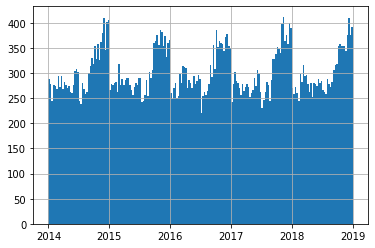

In [93]:
df_synth_sessions_2014_2018["starttime_parking"].hist(bins = 200)

<Axes: >

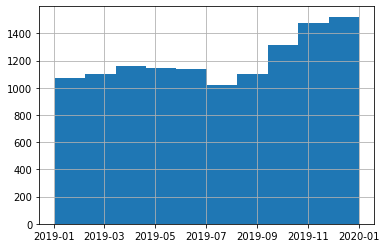

In [94]:
df_synth_sessions_2019["starttime_parking"].hist()

# Scratchpad

In [45]:
df_test = pd.DataFrame({"ts": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]})
df_test["ts"] = df_test["ts"] + 131502
df_test["dt"] = df_test["ts"].apply(ts_to_datetime)
df_test


,ts,dt
0,131502,2015-01-01 06:00:00
1,131503,2015-01-01 07:00:00
2,131504,2015-01-01 08:00:00
3,131505,2015-01-01 09:00:00
4,131506,2015-01-01 10:00:00
5,131507,2015-01-01 11:00:00
6,131508,2015-01-01 12:00:00
7,131509,2015-01-01 13:00:00
8,131510,2015-01-01 14:00:00
9,131511,2015-01-01 15:00:00


In [42]:
ts1 = 131502 
print(ts_to_datetime(ts1,(-1)*(365 * 24)))
print(ts_to_datetime(ts1, (0)*(365 * 24)))
print(ts_to_datetime(ts1, (1)*(365 * 24)))
print(ts_to_datetime(ts1, (2)*(365 * 24)+24))
print(ts_to_datetime(ts1, (3)*(365 * 24)+24))
print(ts_to_datetime(ts1, (4)*(365 * 24)+24))

2014-01-01 06:00:00
2015-01-01 06:00:00
2016-01-01 06:00:00
2017-01-01 06:00:00
2018-01-01 06:00:00
2019-01-01 06:00:00


In [33]:
# Timestamp to datetime
ts = 140252
dt = config.starttime_min + datetime.timedelta(seconds = ts * config.timestep)
date = pd.to_datetime(dt.strftime("%Y-%m-%d 00:00:00"))
print(ts, dt, date)
print(type(ts), type(dt), type(date))

140252 2015-12-31 20:00:00 2015-12-31 00:00:00
<class 'int'> <class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>
